In [2]:
#Yuri Muller Plumm Gomes 
#yurimullergomes@gmail.com
import tensorflow as tf
import keras
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

%matplotlib inline


CATEGORIES = ["Breakouts","fracture","nofracture"]


# First we test if we can open the files:

data0 = pd.read_csv('annotations.csv',sep=',',names = ['img_address','n1','n2','n3','n4','classe'])
classes = pd.read_csv('classes.csv',sep = ',',names = ['classe','number'])


c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import pickle

pickle_in = open("Xreg.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("yreg.pickle","rb")
y = pickle.load(pickle_in)

X = np.array(X) #normalizing data

y = np.array(y)

Visualizando os pontos x e y do centróide $C =( (x-x')/2, (y- y')/2)$ e plotando:

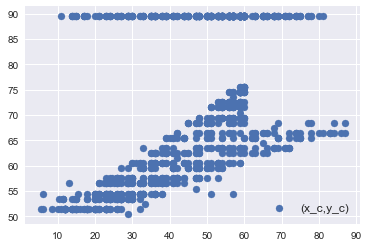

In [4]:
#y[max = 9999][max = 3]
df = 10
X_test = np.array([X[i] for i in range((len(X)//df))])
X_train = np.array([X[i] for i in range((len(X)//df),len(X))])

y_test = np.array([y[i] for i in range((len(y)//df))])
y_train = np.array([y[i] for i in range((len(y)//df),len(y))])

n1 = [y_test[i][0] for i in range(len(y_test))]
n2 = [y_test[i][1] for i in range(len(y_test))]
n3 = [y_test[i][2] for i in range(len(y_test))]
n4 = [y_test[i][3] for i in range(len(y_test))]

xcen = [(n3[i]-n1[i])*0.5 for i in range(len(n1))]
ycen = [(n4[i]-n2[i])*0.5 for i in range(len(n1))]

plt.scatter(xcen,ycen ,label = '(x_c,y_c)')
plt.legend(loc='lower right', shadow=True, fontsize='large')

Agora utilizamos o nosso regressor para predizer dados e plotamos os pontos do centroide preditos:

In [5]:
new_model = tf.keras.models.load_model('reggeo.model') #loading the model
df = 10
X_test = np.array([X[i] for i in range((len(X)//df))])
predictions = new_model.predict([X_test]) #testing the model 

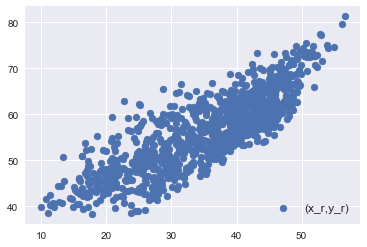

In [6]:
xrcen = [(predictions[i][2] - predictions[i][0])*0.5  for i in range(len(predictions))]
yrcen = [(predictions[i][3] - predictions[i][1])*0.5  for i in range(len(predictions))]

plt.scatter(xrcen,yrcen ,label = '(x_r,y_r)')
plt.legend(loc='lower right', shadow=True, fontsize='large')

Tirando a diferença entre centroides reais e preditos temos os seguintes resultados percentuais $(C_{real} - C_{pred}) / C_{real}$: 

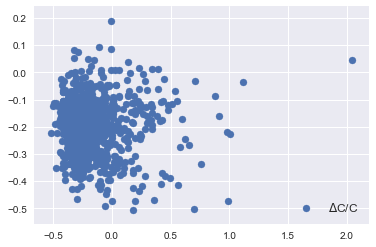

In [7]:
xmax = np.max(xcen)
ymax = np.max(ycen)
deltax = [(xrcen[i] - xcen[i])/xcen[i] for i in range(len(xrcen))] 
deltay = [(yrcen[i] - ycen[i])/ycen[i] for i in range(len(xrcen))] 
plt.scatter(deltax,deltay ,label = '$\Delta$C/C')
plt.legend(loc='lower right', shadow=True, fontsize='large')

Podemos visualizar o módulo da distância da imagem acima fazendo $\Delta R = \sqrt(\Delta x^2  + \Delta y^2)$ e plotando R: 

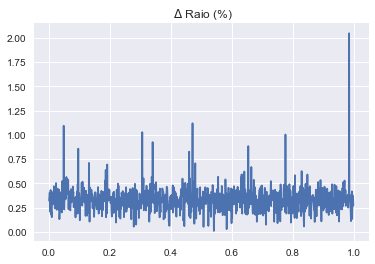

In [12]:
xlin = [i/len(deltax) for i in range(len(deltax))]
dcen = [np.sqrt(deltax[i]**2+ deltay[i]**2) for i in range(len(deltax))]
plt.plot(xlin,dcen)
plt.title(' $\Delta$ Raio (%)')

In [23]:
#media do raio
dcenpd = pd.DataFrame({'dcen':dcen})
meand = dcenpd.mean()
meand[0]

0.33390871007402223

In [24]:
#desvio padrão do raio
stdd = dcenpd.std()
stdd[0]

0.12875456943521021

Podemos agora plotar um histograma do raio:

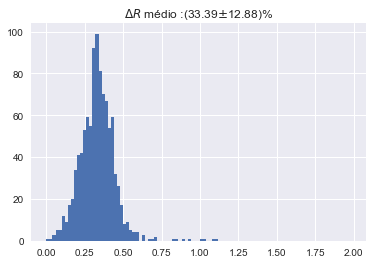

In [25]:

bin_list = [i/50 for i in range(100)]

dcenpd.hist(bins = bin_list)
titled = '$  \Delta R $ médio :('+str(np.around(100*meand[0], decimals=2))+'$\pm$'+str(np.around(100*stdd[0], decimals=2))+')%'
plt.title(titled)

Por fim, podemos calcular a relação entre $\Delta R$ máximo e acerto do regressor. com isso formamos o seguinte gráfico:

In [26]:
sh = 20
threshold = [i/19 for i in range(sh)]
lista_final = []
for thr in threshold: 
    aaa = dcenpd.dcen[dcenpd.dcen < thr].count()
    lista_final.append(aaa/1000)

In [27]:
import numpy as np
from pylab import *
from scipy.optimize import curve_fit

def func(x, b ):

    return(1/(1+np.exp(b*x)))

#data
x_0 = [i/int(len(lista_final)) for i in range(len(lista_final))]
y_0 = lista_final

# curve fit [with only y-error]
popt_0, pcov_0 = curve_fit(func, x_0, y_0) # ,sigma=1./(noise_0*noise_0)
perr_0 = np.sqrt(np.diag(pcov_0))


fit_0 = func(x_0, popt_0)


from scipy import integrate
#f0=func(x_0,popt_0)
AUC = integrate.quad(func, 0, 1,args=popt_0)

print('AUC parameter class 0:',str(AUC[0]) + '+-' + str(AUC[1]) )


AUC parameter class 0: 0.7688499990437254+-8.535949714213735e-15


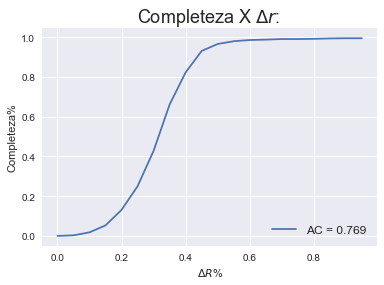

In [46]:
xlin = [i/int(len(lista_final)) for i in range(len(lista_final))]
legenda =  'AC = ' + str(np.around(AUC[0],decimals=3)) #+ '$\pm$'+ str(np.around(AUC[1],decimals=3))
plt.plot(xlin,lista_final,label = legenda)
titled = 'Completeza X $\Delta r$: '

plt.title(titled,fontsize=18)
plt.xlabel('$\Delta R$%')   #name of the X axis
plt.ylabel('Completeza%') #name of the Y axis
plt.legend(loc='lower right',fontsize=12)